In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh


# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
# plt.rcParams['figure.figsize'] = (16,9)

# import mpld3

In [2]:
from gensim.models import Word2Vec

In [3]:
# reload(sdh)

In [4]:
# reload(nn)
import relembed as nn

In [5]:
# reload(eh)
import experiment_helper as eh

In [6]:
shuffle_seed = 20

In [28]:
reload(dh)
DH = dh.DataHandler('data/semeval_wiki_sdp_50000', valid_percent=1, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
419879 total examples :: 415680 training : 4199 valid (99:1 split)
Vocab size: 27070 Dep size: 50 POS size: 18


In [29]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=False, shuffle_seed=shuffle_seed)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [30]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

print(train['targets'][:5]) # small sample

[[254, 214], [406, 25475], [6209, 299], [1210, 622], [699, 3397]]


In [31]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 13


In [32]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM
# normalize them
word_embeddings /= np.sqrt(np.sum(word_embeddings**2, 1, keepdims=True))

22777 / 27070 pretrained


In [33]:
def reset_drnn(model_name='relembed', bi=True, dep_embed_size=25, pos_embed_size=25, 
               word_embed_size=None, max_grad_norm=3., max_to_keep=10,
               supervised=True, interactive=True):
    if word_embed_size:    
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':word_embed_size,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':None,
            'max_grad_norm':3.,
            'model_name':model_name,
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    else: # use pretrained google vectors
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':300,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':word_embeddings,
            'max_grad_norm':3.,
            'model_name':model_name,            
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    drnn = nn.RelEmbed(config)
    print(drnn)
    return drnn
# drnn = reset_drnn()

In [34]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens,_ = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index].reshape((1,2))
    padded_qp = np.zeros([DH.max_seq_len, 3]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    padded_qp[:len(query_phrase), 2] = [x[2] for x in query_phrase]    

    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, query_target,
                                                      valid_phrases, valid_lens, valid_targets)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0,0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[0,1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [35]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

## Unsupervised

In [36]:
reload(nn)
drnn = reset_drnn(model_name='renormalize_inner', bi=False, max_to_keep=0)

# hyperparameters
num_epochs = 5
batch_size =50
neg_per = 10
neg_level= 1
target_neg = True

num_nearby = 50
nearby_mod = 200
sample_power = .75
DH.scale_vocab_dist(sample_power)
DH.scale_target_dist(.5)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    offset = 0 #if epoch else 400
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, offset=offset, 
                                             neg_per=neg_per, neg_level=neg_level, target_neg=target_neg)):
        inputs, targets, labels, lengths, _ = batch
        if not step: step = offset
        t0 = time()
        loss = drnn.partial_unsup_fit(inputs, targets, labels, lengths)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            inputs, targets, labels, lengths, _ = DH.validation_batch()
            valid_loss = drnn.validation_loss(inputs, targets, labels, lengths)
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

(?, 300)
(?,)
(1, 1, 300)
<DPNN: W:300, D:25, P:25 H:300, V:27070>
(0:0:2) step 0/8313, epoch 0 Training Loss = 0.69321 :: 664.410 phrases/sec :: (9:33:25) hours left
Top 50 closest phrases to <interest> '<X> in <Y>' <authors>
0: 1.000 : <interest> '<X> in <Y>' <authors>
1: 0.535 : <device> '<X> remained invented <Y>' <researchers>
2: 0.496 : <who> '<X> makes mention of knowledge of literature <Y>' <writers>
3: 0.432 : <surname> '<X> is common in <Y>' <book>
4: 0.403 : <findings> '<X> with trials published in <Y>' <journals>
5: 0.402 : <floors> '<X> by headquarters of <Y>' <journals>
6: 0.400 : <certificate> '<X> awarded for contribution to <Y>' <literature>
7: 0.393 : <what> '<X> required make delivery of <Y>' <manuscript>
8: 0.391 : <judgment> '<X> of <Y>' <experts>
9: 0.387 : <he> '<X> illustrated <Y>' <books>
10: 0.381 : <novelist> '<X> has <Y>' <novel>
11: 0.370 : <book> '<X> includes <Y>' <essays>
12: 0.366 : <texts> '<X> <Y>' <poems>
13: 0.337 : <readings> '<X> through working o

KeyboardInterrupt: 

(-100, 10000)

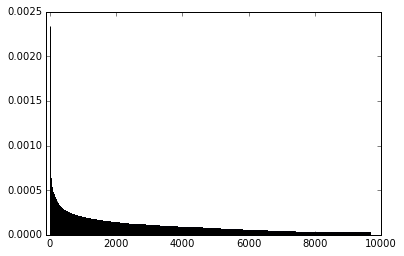

In [20]:
DH.scale_target_dist(.5)
plt.bar(range(len(DH._target_dist)), sorted(DH._target_dist, reverse=True))
plt.xlim(-100,10000)

In [39]:
drnn.checkpoint()

Saving model to file: checkpoints/renormalize_inner.ckpt-25915-0


'checkpoints/renormalize_inner.ckpt-25915-0'

In [37]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [38]:
def confusion_matrix(preds, labels, label_set):
    size = len(label_set)
    matrix = np.zeros([size, size]) # rows are predictions, columns are truths
    # fill in matrix
    for p, l in zip(preds, labels):
        matrix[p,l] += 1
    # compute class specific scores
    class_precision = np.zeros(size)
    class_recall = np.zeros(size)
    for label in range(size):
        tp = matrix[label, label]
        fp = np.sum(matrix[label, :]) - tp
        fn = np.sum(matrix[:, label]) - tp
        class_precision[label] = tp/float(tp + fp) if tp or fp else 0
        class_recall[label] = tp/float(tp + fn) if tp or fn else 0
    micro_f1 = np.array([2*(p*r)/(p+r) if p or r else 0 for (p, r) in zip(class_precision, class_recall)])
    avg_precision = np.mean(class_precision)
    avg_recall = np.mean(class_recall)
    macro_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall) if avg_precision and avg_recall else 0
    stats = {'micro_precision':class_precision*100,
             'micro_recall':class_recall*100, 
             'micro_f1':micro_f1*100,
             'macro_precision':avg_precision*100, 
             'macro_recall':avg_recall*100,
             'macro_f1':macro_f1*100}
    return matrix, stats

In [40]:
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 20
display_mod = 10
valid_mod = 50
best_valid = 10e6
early_stop_model = None
start = time()
for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False)
        xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, xent))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
            print("="*80)
            model_file = drnn.checkpoint()
            if valid_xent < best_valid:
                print("New best validation")
                best_valid = valid_xent
                early_stop_model = model_file
    valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
    label_set = set(train['labels'])
    preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
    cm, stats = confusion_matrix(preds, valid['labels'], label_set)
    print("Macro F1: %2.4f" % stats['macro_f1'])
# do a final validation
valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
print("="*80)


model_file = drnn.checkpoint()
if valid_xent < best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

(0:0:1) s 0/143, e 0 avg class xent loss = 2.9431
(0:0:2) s 0/143, e 0 validation avg class xent loss = 2.9309
Saving model to file: checkpoints/renormalize_inner.ckpt-25915-1
New best validation
(0:0:22) s 10/143, e 0 avg class xent loss = 2.9097
(0:0:34) s 20/143, e 0 avg class xent loss = 2.8806
(0:0:45) s 30/143, e 0 avg class xent loss = 2.8513
(0:0:57) s 40/143, e 0 avg class xent loss = 2.7975
(0:1:8) s 50/143, e 0 avg class xent loss = 2.7782
(0:1:9) s 50/143, e 0 validation avg class xent loss = 2.7735
Saving model to file: checkpoints/renormalize_inner.ckpt-25915-51
New best validation
(0:1:32) s 60/143, e 0 avg class xent loss = 2.7944
(0:1:44) s 70/143, e 0 avg class xent loss = 2.7744
(0:1:55) s 80/143, e 0 avg class xent loss = 2.5333
(0:2:7) s 90/143, e 0 avg class xent loss = 2.3574
(0:2:18) s 100/143, e 0 avg class xent loss = 2.6745
(0:2:19) s 100/143, e 0 validation avg class xent loss = 2.5838
Saving model to file: checkpoints/renormalize_inner.ckpt-25915-101
New be

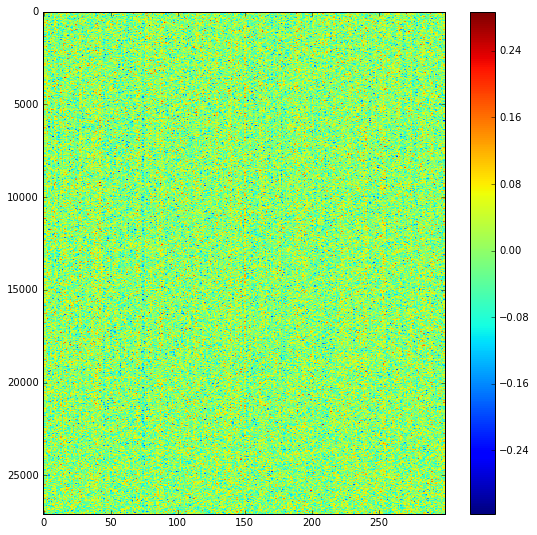

In [41]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(word_embeddings, aspect='auto', interpolation='nearest')
plt.colorbar(im)

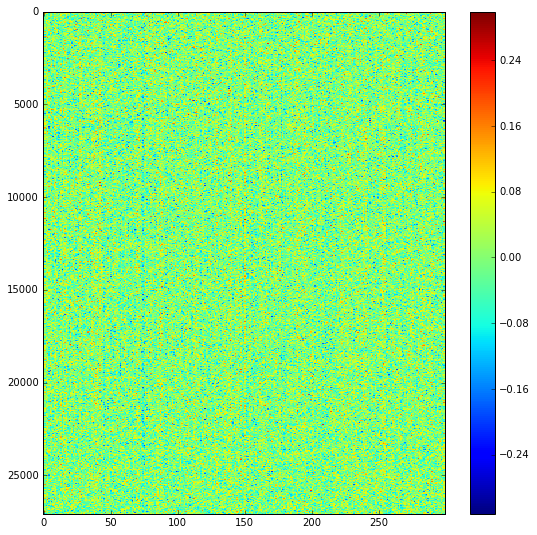

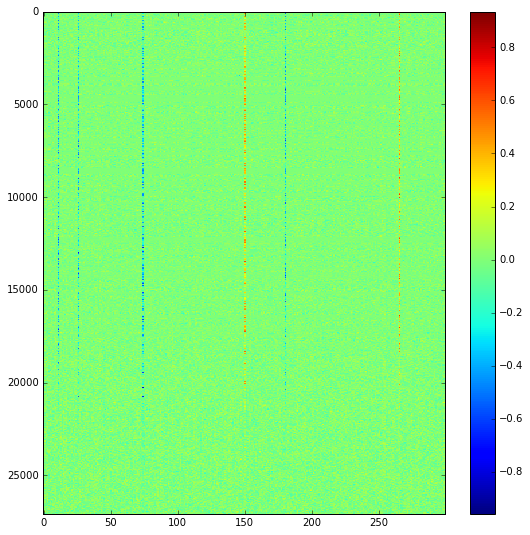

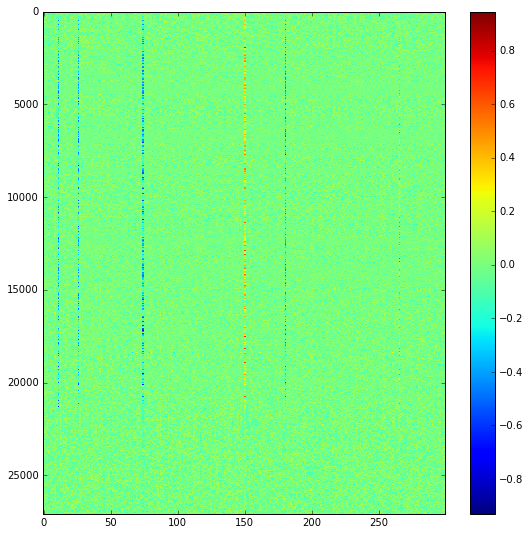

In [46]:
words = drnn._word_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(words, aspect='auto', interpolation='nearest')
plt.colorbar(im)

words = drnn._left_target_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(words, aspect='auto', interpolation='nearest')
plt.colorbar(im)

words = drnn._right_target_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(words, aspect='auto', interpolation='nearest')
plt.colorbar(im)

<function print>

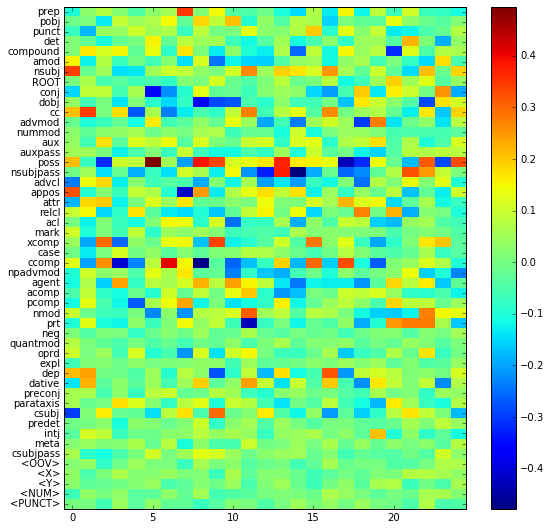

In [43]:
embeds = drnn._dependency_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
plt.colorbar(im)
ax.set_yticklabels(DH._dep_vocab)
ax.set_yticks(range(len(DH._dep_vocab)))
print

<function print>

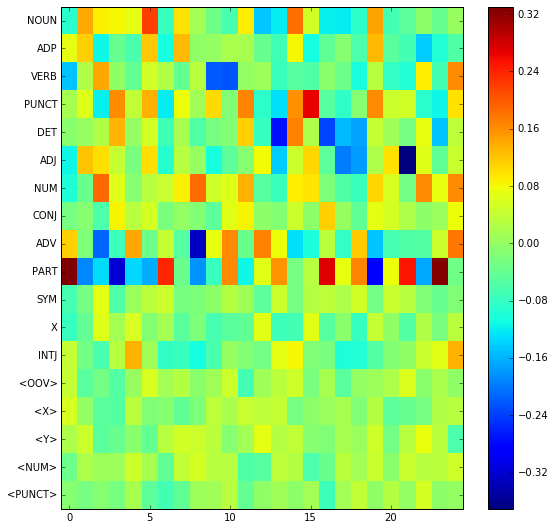

In [44]:
embeds = drnn._pos_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
plt.colorbar(im)
ax.set_yticklabels(DH._pos_vocab)
ax.set_yticks(range(len(DH._pos_vocab)))
print

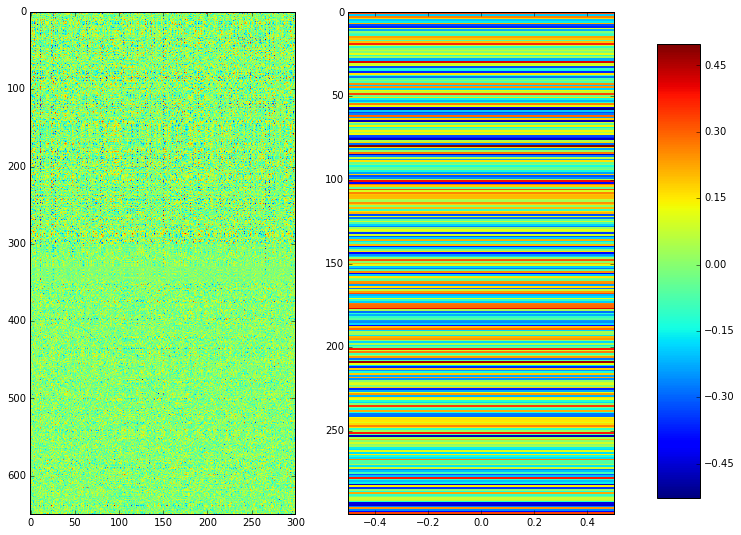

In [47]:
embeds = tf.get_variable('RNN/GRUCell/Candidate/Linear/Matrix').eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = tf.get_variable('RNN/GRUCell/Candidate/Linear/Bias').eval().reshape([-1,1])
ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
### Top half is input, bottom is r*candidate

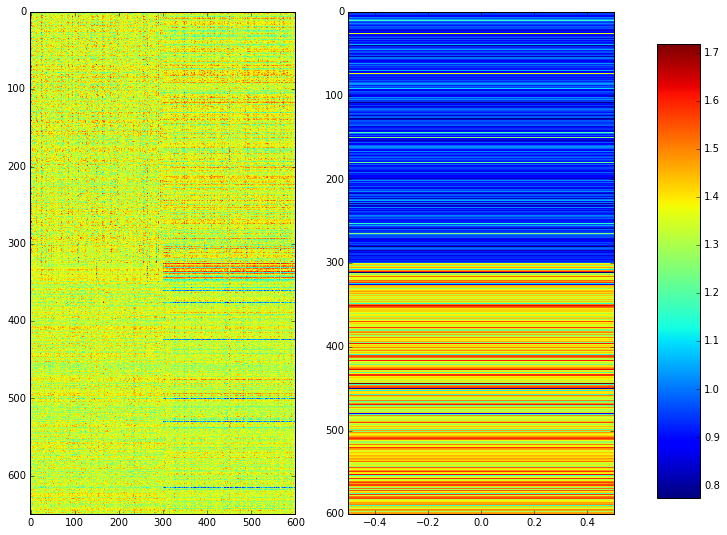

In [48]:
embeds = tf.get_variable('RNN/GRUCell/Gates/Linear/Matrix').eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = tf.get_variable('RNN/GRUCell/Gates/Linear/Bias').eval().reshape([-1,1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# left is r, right is z